In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, StandardScaler, minmax_scale
from torch.utils.data import DataLoader, Dataset, TensorDataset

from main_event import prepare_event_data, prepare_json_event_data
from models.neural_network import NeuralNetwork
from models.main import get_model, train_model
from preprocessing import PreProcessing
from utils import (
    add_shot_prediction_features,
    calculate_velocity_acceleration,
    calculate_velocity_direction,
    calculate_velocity_acceleration_direction,
    get_frame_data,
    plot_accuracy_history,
    plot_confusion_matrix,
    calculate_player_ball_distances,
    track_closest_players,
    get_n_smallest_indices_sorted
)

## You'll see the data goes from 0 to 1 on each axis. The coordiante (0,0) is the top left, (1,1) is the bottom right, and (0.5,0.5) is the kick off point.

In [2]:
game_1_pre = PreProcessing()
game_1_data = game_1_pre.load_and_process_data(
    data_home="data/Sample_Game_1/Sample_Game_1_RawTrackingData_Home_Team.csv", 
    data_away="data/Sample_Game_1/Sample_Game_1_RawTrackingData_Away_Team.csv", 
    add_ball_data=True, 
    remove_ball_nan=False
)

In [3]:
game_2_pre = PreProcessing()
game_2_data = game_2_pre.load_and_process_data(
    data_home="data/Sample_Game_2/Sample_Game_2_RawTrackingData_Home_Team.csv", 
    data_away="data/Sample_Game_2/Sample_Game_2_RawTrackingData_Away_Team.csv", 
    add_ball_data=True, 
    remove_ball_nan=False
)

In [4]:
game_3_pre = PreProcessing()
game_3_data = game_3_pre.load_and_process_json_data(
    data_home_away="data/Sample_Game_3/Sample_Game_3_tracking.txt", 
    add_ball_data=True, 
    remove_ball_nan=False
)

In [5]:
# game_1_data.iloc[:, 25:-2] = -1 * game_1_data.iloc[:, 25:-2] 1414:1425
game_1_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1.0,1.0,0.04,0.00082,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383,0.45472,0.38709
2,1.0,2.0,0.08,0.00096,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383,0.49645,0.40656
3,1.0,3.0,0.12,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383,0.53716,0.42556
4,1.0,4.0,0.16,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,...,0.55236,0.43313,0.50034,0.94391,0.43644,0.05038,0.37756,0.27473,0.55346,0.42231
5,1.0,5.0,0.20,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,...,0.55202,0.43311,0.50017,0.94434,0.43580,0.04977,0.37663,0.27543,0.55512,0.40570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,2.0,145002.0,5800.08,0.90614,0.45355,0.30044,0.68311,0.34157,0.64598,0.31228,...,0.10317,0.81976,0.19836,0.45137,0.29416,0.48874,0.35600,0.55371,0.03058,0.99726
145003,2.0,145003.0,5800.12,0.90550,0.45355,0.30044,0.68311,0.34127,0.64583,0.31230,...,0.10319,0.81960,0.19831,0.45182,0.29373,0.48836,0.35583,0.55283,0.03058,0.99726
145004,2.0,145004.0,5800.16,0.90492,0.45355,0.30044,0.68311,0.34089,0.64569,0.31214,...,0.10285,0.81944,0.19805,0.45200,0.29331,0.48800,0.35561,0.55254,0.03058,0.99726
145005,2.0,145005.0,5800.20,0.90456,0.45356,0.30044,0.68311,0.34056,0.64552,0.31171,...,0.10231,0.81944,0.19766,0.45237,0.29272,0.48789,0.35532,0.55243,0.03058,0.99726


In [6]:
# game_2_data.iloc[:, 25:-2] = -1 * game_2_data.iloc[:, 25:-2]
game_2_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1.0,1.0,0.04,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
2,1.0,2.0,0.08,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
3,1.0,3.0,0.12,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
4,1.0,4.0,0.16,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
5,1.0,5.0,0.20,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,2.0,141152.0,5646.08,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46751,1.05000,0.44966,0.41572,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891
141153,2.0,141153.0,5646.12,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46790,1.05000,0.44983,0.41550,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891
141154,2.0,141154.0,5646.16,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46818,1.05000,0.44997,0.41485,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891
141155,2.0,141155.0,5646.20,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46855,1.05000,0.45017,0.41515,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891


In [7]:
game_3_data

,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1,0.04,0.84722,0.52855,0.65268,0.24792,0.66525,0.46562,0.68103,0.59083,...,0.41787,0.48086,0.41215,0.36689,0.47050,0.73219,0.48864,0.36357,0.50125,0.48725
2,2,0.08,0.84722,0.52855,0.65231,0.24513,0.66482,0.46548,0.68095,0.59054,...,0.41719,0.47864,0.41132,0.36169,0.47040,0.73204,0.48834,0.36362,0.50125,0.48725
3,3,0.12,0.84722,0.52855,0.65197,0.24387,0.66467,0.46537,0.68078,0.59035,...,0.41697,0.47824,0.41131,0.36072,0.47075,0.73229,0.48814,0.36372,0.50125,0.48725
4,4,0.16,0.84722,0.52855,0.65166,0.24288,0.66460,0.46488,0.68063,0.58987,...,0.41685,0.47815,0.41117,0.35930,0.47118,0.73266,0.48793,0.36278,0.50125,0.48725
5,5,0.20,0.84722,0.52855,0.65141,0.24251,0.66452,0.46469,0.68052,0.58934,...,0.41669,0.47749,0.41120,0.35910,0.47163,0.73287,0.48784,0.36240,0.50125,0.48725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,143757,5750.28,0.11993,0.51783,0.47808,0.45408,0.49691,0.77311,0.46373,0.62102,...,0.58877,0.56936,0.50218,0.65158,0.46978,0.62349,0.80792,0.27106,0.89207,0.50485
143758,143758,5750.32,0.11993,0.51783,0.47786,0.45521,0.49701,0.77429,0.46381,0.62046,...,0.58787,0.56961,0.50180,0.65115,0.46970,0.62403,0.80712,0.27184,0.89207,0.50485
143759,143759,5750.36,0.11993,0.51783,0.47743,0.45709,0.49686,0.77555,0.46358,0.62117,...,0.58668,0.57038,0.50116,0.65071,0.46929,0.62479,0.80582,0.27242,0.89207,0.50485
143760,143760,5750.40,0.11993,0.51783,0.47669,0.45947,0.49676,0.77638,0.46306,0.62339,...,0.58525,0.57033,0.50031,0.65134,0.46866,0.62611,0.80444,0.27260,0.89207,0.50485


## Tracking for individual Players for the First Period

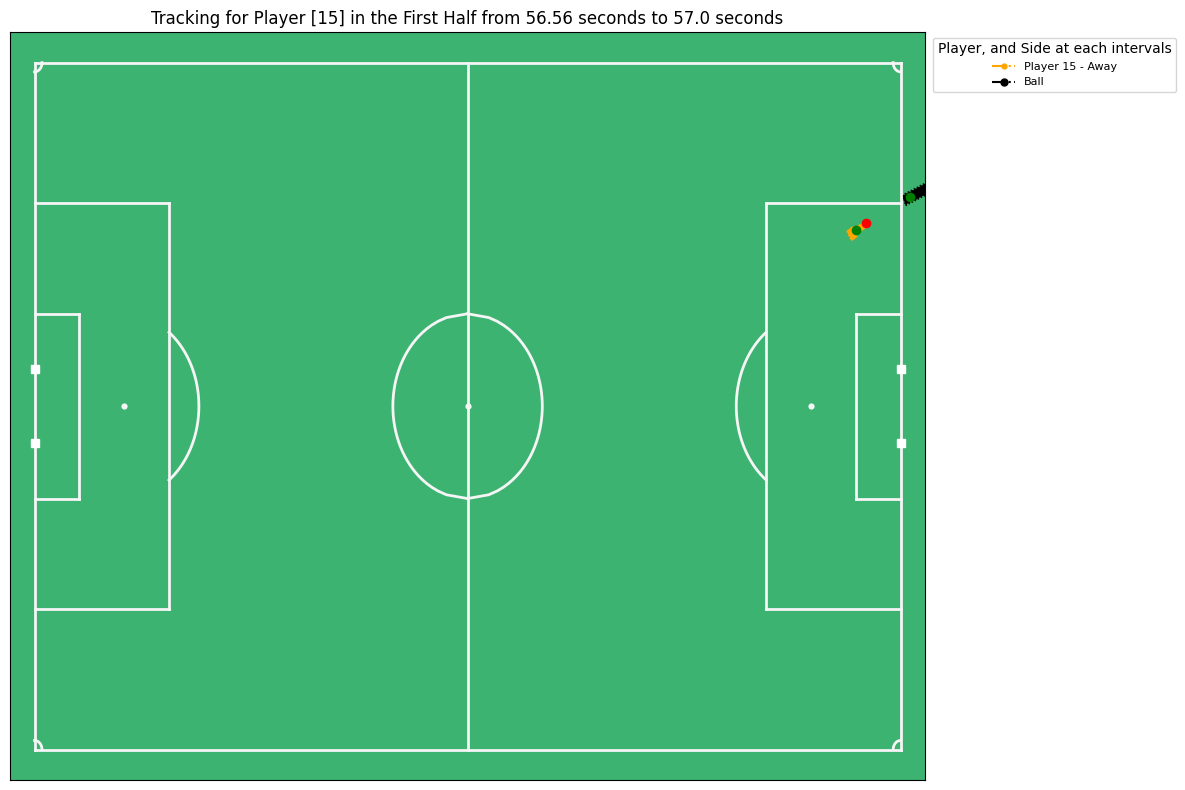

In [8]:
game_2_pre.player_visualization(game_1_data.loc[1414:1425], players=[15], sides=["Away"]*1, plot_ball=True)

In [9]:
# player_tracking(period_1_data)
# player_tracking(period_1_data_home, [2])
# player_tracking(period_1_data_home, [5])
# player_tracking(period_1_data_home, [8])

# Adding extra features to dataset

In [10]:
def calculate_velocity_acceleration_direction(dataset: pd.DataFrame, normalize: bool = True) -> pd.DataFrame:
    """
    Calculates the velocity, acceleration and direction of players and ball in a given dataset.

    Parameters:
        dataset (pandas.DataFrame): The input dataset containing player and ball positions over time.
        normalize (bool): Whether to normalize the calculated values.

    Returns:
        pandas.DataFrame: The original dataset with additional columns for velocity, acceleration and direction.
    """
    temp_data = dataset.copy()
    start_idx = temp_data.columns.get_loc("Time [s]")
    player_columns = temp_data.columns[start_idx + 1:]
    
    # Store all velocities/accelerations for global scaling
    all_velocities = []
    all_accelerations = []
    player_vel_mapping = {}
    player_acc_mapping = {}
    player_sin_mapping = {}
    player_cos_mapping = {}
    
    # First calculate all values
    for i in range(0, player_columns.shape[0] - 1, 2):
        ply_x, ply_y = player_columns[i], player_columns[i + 1]
        
        x_diff = temp_data[ply_x].diff()
        y_diff = temp_data[ply_y].diff()
        time_diff = temp_data["Frame"].diff()
        
        distance = np.sqrt(x_diff ** 2 + y_diff ** 2)
        velocity = distance / time_diff
        acceleration = velocity.diff() / time_diff
        
        # Calculate direction
        vel_x = x_diff / time_diff
        vel_y = y_diff / time_diff
        direction_rad = np.arctan2(vel_y, vel_x)
        
        direction_sine = np.sin(direction_rad)
        direction_cosine = np.cos(direction_rad)
        
        # Store values for later scaling and ordering
        if "Ball" in ply_x:
            entity = "Ball"
                            
            player_vel_mapping[entity] = velocity
            player_acc_mapping[entity] = acceleration
            player_sin_mapping[entity] = direction_sine
            player_cos_mapping[entity] = direction_cosine
            
            all_velocities.extend(velocity.dropna().tolist())
            all_accelerations.extend(acceleration.dropna().tolist())
    
    # Apply global scaling if requested
    if normalize:
        scaler_vel = MinMaxScaler(feature_range=(-1, 1))
        scaler_acc = MinMaxScaler(feature_range=(-1, 1))
        
        # Fit the scalers on all values
        scaler_vel.fit(np.array(all_velocities).reshape(-1, 1))
        scaler_acc.fit(np.array(all_accelerations).reshape(-1, 1))
        
        # Transform the values
        for entity in player_vel_mapping:
            player_vel_mapping[entity] = scaler_vel.transform(player_vel_mapping[entity].values.reshape(-1, 1)).flatten()
            player_acc_mapping[entity] = scaler_acc.transform(player_acc_mapping[entity].values.reshape(-1, 1)).flatten()
    
    # Add columns to dataframe in the desired order: velocity, acceleration, direction
    for entity in player_vel_mapping.keys():  # Sort to ensure consistent order
        temp_data[f"{entity}_velocity"] = player_vel_mapping[entity]
        temp_data[f"{entity}_acceleration"] = player_acc_mapping[entity]
        temp_data[f"{entity}_direction_sin"] = player_sin_mapping[entity]
        temp_data[f"{entity}_direction_cos"] = player_cos_mapping[entity]
    
    return temp_data

In [8]:
vel_acc_game_1_data = calculate_velocity_acceleration_direction(game_1_data)
vel_acc_game_2_data = calculate_velocity_acceleration_direction(game_2_data)
vel_acc_game_3_data = calculate_velocity_acceleration_direction(game_3_data)

In [9]:
vel_acc_game_1_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,P_23_direction_sin,P_23_direction_cos,P_9_velocity,P_9_acceleration,P_9_direction_sin,P_9_direction_cos,P_10_velocity,P_10_acceleration,P_10_direction_sin,P_10_direction_cos
1,1.0,1.0,0.04,0.00082,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>
2,1.0,2.0,0.08,0.00096,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.0,1.0,-1.000000,NaN,0.0,1.0,-1.000000,NaN,0.0,1.0
3,1.0,3.0,0.12,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.0,1.0,-1.000000,0.000000,0.0,1.0,-1.000000,0.000000,0.0,1.0
4,1.0,4.0,0.16,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,...,0.592076,-0.805882,-0.999242,0.000379,0.661622,0.749838,-0.999255,0.000372,0.98758,-0.157115
5,1.0,5.0,0.20,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,...,-0.689938,-0.723869,-0.999667,-0.000212,-0.953583,0.301131,-0.999431,-0.000088,-0.058722,-0.998274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,2.0,145002.0,5800.08,0.90614,0.45355,0.30044,0.68311,0.34157,0.64598,0.31228,...,-0.697865,-0.71623,-0.999270,-0.000043,-0.939123,0.343582,-0.999538,-0.000047,0.21693,-0.976187
145003,2.0,145003.0,5800.12,0.90550,0.45355,0.30044,0.68311,0.34127,0.64583,0.31230,...,-0.662198,-0.749329,-0.999075,0.000098,-0.994102,0.108448,-0.999439,0.000049,-0.447214,-0.894427
145004,2.0,145004.0,5800.16,0.90492,0.45355,0.30044,0.68311,0.34089,0.64569,0.31214,...,-0.650791,-0.759257,-0.999799,-0.000362,-0.664364,-0.747409,-0.999323,0.000058,-0.345705,-0.938343
145005,2.0,145005.0,5800.20,0.90456,0.45356,0.30044,0.68311,0.34056,0.64552,0.31171,...,-0.183282,-0.98306,-0.999429,0.000185,-0.351123,-0.936329,-0.999379,-0.000028,-0.457957,-0.888975


In [10]:
vel_acc_game_3_data

,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,...,P_23_direction_sin,P_23_direction_cos,P_9_velocity,P_9_acceleration,P_9_direction_sin,P_9_direction_cos,P_10_velocity,P_10_acceleration,P_10_direction_sin,P_10_direction_cos
1,1,0.04,0.84722,0.52855,0.65268,0.24792,0.66525,0.46562,0.68103,0.59083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0.08,0.84722,0.52855,0.65231,0.24513,0.66482,0.46548,0.68095,0.59054,...,-0.832050,-0.554700,-0.999168,NaN,-0.254493,-0.967075,-0.992988,NaN,-0.999544,-0.030198
3,3,0.12,0.84722,0.52855,0.65197,0.24387,0.66467,0.46537,0.68078,0.59035,...,0.581238,0.813733,-0.998901,0.000134,-0.962964,-0.269630,-0.999775,-0.003394,-0.752577,0.658505
4,4,0.16,0.84722,0.52855,0.65166,0.24288,0.66460,0.46488,0.68063,0.58987,...,0.652242,0.758011,-0.998921,-0.000010,-0.961524,-0.274721,-0.999767,0.000004,0.000000,1.000000
5,5,0.20,0.84722,0.52855,0.65141,0.24251,0.66452,0.46469,0.68052,0.58934,...,0.422885,0.906183,-0.999430,-0.000254,-0.854199,-0.519947,-0.999687,0.000040,0.474100,0.880471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,143757,5750.28,0.11993,0.51783,0.47808,0.45408,0.49691,0.77311,0.46373,0.62102,...,-0.915315,-0.402739,-0.999303,0.000113,0.334410,-0.942428,-0.999634,-0.000433,0.173785,-0.984784
143758,143758,5750.32,0.11993,0.51783,0.47786,0.45521,0.49701,0.77429,0.46381,0.62046,...,0.989203,-0.146549,-0.999030,0.000137,0.589469,-0.807791,-0.998518,0.000558,0.714213,-0.699929
143759,143759,5750.36,0.11993,0.51783,0.47743,0.45709,0.49686,0.77555,0.46358,0.62117,...,0.880099,-0.474790,-0.998966,0.000032,-0.388972,-0.921250,-0.998049,0.000234,0.358251,-0.933625
143760,143760,5750.40,0.11993,0.51783,0.47669,0.45947,0.49676,0.77638,0.46306,0.62339,...,0.902481,-0.430730,-0.997731,0.000617,-0.643848,-0.765153,-0.997665,0.000192,-0.625800,-0.779983


In [11]:
game_1_ply_tra = vel_acc_game_1_data.iloc[:, 3:]
game_2_ply_tra = vel_acc_game_2_data.iloc[:, 3:]
game_3_ply_tra = vel_acc_game_3_data.iloc[:, 2:] # This is different

In [12]:
game_2_ply_tra

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,P_23_direction_sin,P_23_direction_cos,P_9_velocity,P_9_acceleration,P_9_direction_sin,P_9_direction_cos,P_10_velocity,P_10_acceleration,P_10_direction_sin,P_10_direction_cos
1,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>
2,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.0,1.0,-1.000000,NaN,0.0,1.0,-1.000000,NaN,0.0,1.0
3,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.0,1.0,-1.000000,0.000000,0.0,1.0,-1.000000,0.000000,0.0,1.0
4,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.0,1.0,-1.000000,0.000000,0.0,1.0,-1.000000,0.000000,0.0,1.0
5,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.0,1.0,-1.000000,0.000000,0.0,1.0,-1.000000,0.000000,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.0,1.0,-0.998529,-0.000009,0.480833,-0.876812,-0.999022,-0.000015,0.489251,0.872143
141153,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.0,1.0,-0.997772,0.000378,0.821856,-0.569696,-0.998953,0.000035,0.357647,0.933857
141154,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.0,1.0,-0.997072,0.000350,0.952176,-0.305549,-0.999513,-0.000280,0.341743,0.939793
141155,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.0,1.0,-0.998697,-0.000813,0.447214,-0.894427,-0.999284,0.000114,-0.581238,0.813733


In [13]:
# game_1_player_data = get_frame_data(game_1_ply_tra, columns=game_1_ply_tra.columns[0:46:2], feature="direction").fillna(0)
# game_2_player_data = get_frame_data(game_2_ply_tra, columns=game_2_ply_tra.columns[0:46:2], feature="direction").fillna(0)
# game_3_player_data = get_frame_data(game_3_ply_tra, columns=game_3_ply_tra.columns[0:46:2], feature="direction").fillna(0)

In [14]:
game_1_player_data = game_1_ply_tra.fillna(0).copy()
game_2_player_data = game_2_ply_tra.fillna(0).copy()
game_3_player_data = game_3_ply_tra.fillna(0).copy()

In [15]:
game_1_player_data = add_shot_prediction_features(game_1_player_data)
game_2_player_data = add_shot_prediction_features(game_2_player_data)
game_3_player_data = add_shot_prediction_features(game_3_player_data)

In [16]:
game_1_player_data

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,P_9_velocity,P_9_acceleration,P_9_direction_sin,P_9_direction_cos,P_10_velocity,P_10_acceleration,P_10_direction_sin,P_10_direction_cos,Ball_nearest_goal_distance,Ball_shot_probability
1,0.00082,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,0.35529,0.32137,0.21262,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.468528,0.0
2,0.00096,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,0.35529,0.32137,0.21262,...,-1.000000,0.000000,0.0,1.0,-1.000000,0.000000,0.0,1.0,0.505167,0.0
3,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,0.35529,0.32137,0.21262,...,-1.000000,0.000000,0.0,1.0,-1.000000,0.000000,0.0,1.0,0.468788,0.0
4,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,0.35554,0.32142,0.21241,...,-0.999242,0.000379,0.661622,0.749838,-0.999255,0.000372,0.98758,-0.157115,0.453248,0.0
5,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,0.35528,0.32136,0.21159,...,-0.999667,-0.000212,-0.953583,0.301131,-0.999431,-0.000088,-0.058722,-0.998274,0.454764,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,0.90614,0.45355,0.30044,0.68311,0.34157,0.64598,0.31228,0.67513,0.11428,0.92765,...,-0.999270,-0.000043,-0.939123,0.343582,-0.999538,-0.000047,0.21693,-0.976187,0.498199,0.0
145003,0.90550,0.45355,0.30044,0.68311,0.34127,0.64583,0.31230,0.67529,0.11428,0.92765,...,-0.999075,0.000098,-0.994102,0.108448,-0.999439,0.000049,-0.447214,-0.894427,0.498199,0.0
145004,0.90492,0.45355,0.30044,0.68311,0.34089,0.64569,0.31214,0.67501,0.11428,0.92765,...,-0.999799,-0.000362,-0.664364,-0.747409,-0.999323,0.000058,-0.345705,-0.938343,0.498199,0.0
145005,0.90456,0.45356,0.30044,0.68311,0.34056,0.64552,0.31171,0.67468,0.11428,0.92765,...,-0.999429,0.000185,-0.351123,-0.936329,-0.999379,-0.000028,-0.457957,-0.888975,0.498199,0.0


# Classification

In [17]:
game_1_event = prepare_event_data("data/Sample_Game_1/Sample_Game_1_RawEventsData.csv", game_1_data)
game_2_event = prepare_event_data("data/Sample_Game_2/Sample_Game_2_RawEventsData.csv", game_2_data)
game_3_event = prepare_json_event_data("data/Sample_Game_3/Sample_Game_3_events.json", game_3_data)

In [18]:
game_1_event

,Type
3,PASS
4,PASS
5,PASS
6,PASS
7,PASS
...,...
143614,BALL LOST
143615,BALL LOST
143616,BALL LOST
143617,BALL LOST


In [19]:
game_2_event

,Type
146,PASS
147,PASS
148,PASS
149,PASS
150,PASS
...,...
141152,BALL OUT
141153,BALL OUT
141154,BALL OUT
141155,BALL OUT


In [20]:
game_3_event

,Type
384,PASS
385,PASS
386,PASS
387,PASS
388,PASS
...,...
143529,PASS
143530,PASS
143531,PASS
143532,PASS


In [21]:
common_indices = game_1_event.index.intersection(game_1_player_data.index)
X_1 = game_1_player_data.loc[common_indices]
y_1 = game_1_event.loc[common_indices]

assert X_1.shape[0] == y_1.shape[0]

In [22]:
common_indices = game_2_event.index.intersection(game_2_player_data.index)
X_2 = game_2_player_data.loc[common_indices]
y_2 = game_2_event.loc[common_indices]

assert X_2.shape[0] == y_2.shape[0]

In [23]:
common_indices = game_3_event.index.intersection(game_3_player_data.index)
X_3 = game_3_player_data.loc[common_indices]
y_3 = game_3_event.loc[common_indices]

assert X_3.shape[0] == y_3.shape[0]

In [24]:
X_1

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,P_9_velocity,P_9_acceleration,P_9_direction_sin,P_9_direction_cos,P_10_velocity,P_10_acceleration,P_10_direction_sin,P_10_direction_cos,Ball_nearest_goal_distance,Ball_shot_probability
3,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,0.35529,0.32137,0.21262,...,-1.000000,0.000000,0.0,1.0,-1.000000,0.000000,0.0,1.0,0.468788,0.0
4,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,0.35554,0.32142,0.21241,...,-0.999242,0.000379,0.661622,0.749838,-0.999255,0.000372,0.98758,-0.157115,0.453248,0.0
5,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,0.35528,0.32136,0.21159,...,-0.999667,-0.000212,-0.953583,0.301131,-0.999431,-0.000088,-0.058722,-0.998274,0.454764,0.0
6,0.00140,0.48238,0.32581,0.65159,0.33637,0.48966,0.30978,0.35479,0.32159,0.21051,...,-0.997626,0.001021,-0.999777,0.021122,-0.991294,0.004068,-0.99461,0.103685,0.456896,0.0
7,0.00140,0.48238,0.32570,0.65037,0.33624,0.48919,0.31015,0.35439,0.32198,0.20921,...,-0.996722,0.000452,-0.999532,0.030598,-0.995784,-0.002245,-0.979342,0.202212,0.459624,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143614,0.87621,0.48890,0.25147,0.54818,0.47196,0.44820,0.50936,0.57808,0.11104,0.67714,...,-0.998948,0.000005,-0.715007,-0.699118,-0.998482,-0.000015,0.429506,-0.903064,0.152242,1.0
143615,0.87601,0.48911,0.25096,0.54821,0.47157,0.44844,0.50890,0.57796,0.11004,0.67616,...,-0.998971,-0.000012,-0.731055,-0.682318,-0.998472,0.000005,0.503191,-0.864175,0.147184,1.0
143616,0.87583,0.48933,0.25045,0.54823,0.47120,0.44872,0.50844,0.57788,0.10914,0.67526,...,-0.998956,0.000008,-0.768221,-0.640184,-0.998526,-0.000027,0.487567,-0.873085,0.142133,1.0
143617,0.87564,0.48954,0.24996,0.54830,0.47084,0.44899,0.50799,0.57768,0.10829,0.67433,...,-0.999073,-0.000059,-0.775562,-0.631271,-0.998578,-0.000026,0.493606,-0.869686,0.137069,1.0


### Adding which team has the ball using distance metrics

In [25]:
def add_team_with_ball(event_df, full_data):
    events_to_leave_out=["FAULT RECEIVED", "SET PIECE", "CARD", "CHALLENGE"]
    game_event_data = pd.read_csv(event_df)    
    game_event_data = game_event_data[~(game_event_data["Type"].isin(events_to_leave_out))]
    event_data = game_event_data.replace("RECOVERY", "BALL LOST")    

    ball_out_idx = full_data.index[
        (full_data["Ball-x"] < 0) | (full_data["Ball-x"] > 1) |
        (full_data["Ball-y"] < 0) | (full_data["Ball-y"] > 1)
    ]

    ball_out_df = pd.DataFrame({
        "Team": "BALL OUT"
    }, index=ball_out_idx)
    
    event_data = event_data[~(event_data["Type"] == "BALL OUT")]
    start_frames = event_data["Start Frame"].iloc[1:].to_numpy()
    end_frames = event_data["End Frame"].iloc[1:].to_numpy()
    event_types = event_data["Team"].iloc[1:].to_numpy()

    # Validation
    assert start_frames.shape == end_frames.shape == event_types.shape

    # Ensure end frames don't exceed data bounds
    end = full_data.index[-1]
    end_frames = np.minimum(end_frames, end)

    # Create frame ranges and unique indices
    frame_ranges = [np.arange(min(i, j), max(i, j) + 1)
                    for i, j in zip(start_frames, end_frames)]
    unique_indices = np.unique(np.concatenate(frame_ranges))

    # Create and populate event DataFrame
    event_df = pd.DataFrame(index=unique_indices, columns=["Team"])
    for s, e, e_t in zip(start_frames, end_frames, event_types):
        event_df.loc[s:e, "Team"] = e_t
        
    combined_event_df = ball_out_df.combine_first(event_df)
    
    return replace_c_with_previous(combined_event_df.dropna())

In [26]:
def add_team_with_ball_json(event_df, full_data):
    import json

    with open(event_df, "r") as f:
        event = json.load(f)
        
    type_ = np.array([])
    team_ = np.array([])
    start_frame = np.array([])
    end_frame = np.array([])
    
    for i in event["data"]:
        t = i["type"]["name"]
        te = i["team"]["name"]
        sf = i["start"]["frame"]
        ef = i["end"]["frame"]
    
        if t != "CARRY" and t != "BALL OUT":
            type_ = np.append(type_, t)
            team_ = np.append(team_, te)
            start_frame = np.append(start_frame, sf)
            end_frame = np.append(end_frame, ef)
    
    
    game_event_data = pd.DataFrame({"Type": type_, "Team": team_, "Start Frame": start_frame.astype(np.int64), "End Frame": end_frame.astype(np.int64)})
    events_to_leave_out=["FAULT RECEIVED", "SET PIECE", "CARD", "CHALLENGE"]

    game_event_data = game_event_data[~(game_event_data["Type"].isin(events_to_leave_out))]


    event_data = game_event_data.replace("RECOVERY", "BALL LOST")
    ball_out_idx = full_data.index[
        (full_data["Ball-x"] < 0) | (full_data["Ball-x"] > 1) |
        (full_data["Ball-y"] < 0) | (full_data["Ball-y"] > 1)
    ]

    ball_out_df = pd.DataFrame({
        "Team": "BALL OUT"
    }, index=ball_out_idx)
    
    event_data = event_data[~(event_data["Type"] == "BALL OUT")]
    start_frames = event_data["Start Frame"].iloc[1:].to_numpy()
    end_frames = event_data["End Frame"].iloc[1:].to_numpy()
    event_types = event_data["Team"].iloc[1:].to_numpy()

    # Validation
    assert start_frames.shape == end_frames.shape == event_types.shape

    # Ensure end frames don't exceed data bounds
    end = full_data.index[-1]
    end_frames = np.minimum(end_frames, end)

    # Create frame ranges and unique indices
    frame_ranges = [np.arange(min(i, j), max(i, j) + 1)
                    for i, j in zip(start_frames, end_frames)]
    unique_indices = np.unique(np.concatenate(frame_ranges))

    # Create and populate event DataFrame
    event_df = pd.DataFrame(index=unique_indices, columns=["Team"])
    for s, e, e_t in zip(start_frames, end_frames, event_types):
        event_df.loc[s:e, "Team"] = e_t
        
    combined_event_df = ball_out_df.combine_first(event_df)
    
    return replace_c_with_previous(combined_event_df.dropna())

In [27]:
def replace_c_with_previous(df):
    prev_value = None
    new_types = []

    for val in df['Team']:
        if val != 'BALL OUT':
            prev_value = val
            new_types.append(val)
        else:
            new_types.append(prev_value)

    df['Team'] = new_types
    return df

In [28]:
def add_ball_with(closest_to_ball: pd.DataFrame):
    # Assume the column of interest is the first column.
    col = closest_to_ball.iloc[:, 0].str.lower()
    
    # Use numpy.where to vectorize the assignment.
    team = np.where(col.str.startswith("home"), 0, 
                    np.where(col.str.startswith("away"), 1, np.nan))
    
    return team

def add_ball_with_json(closest_to_ball: pd.DataFrame):
    # Assume the column of interest is the first column.
    col = closest_to_ball.iloc[:, 0].str.lower()
    
    # Use numpy.where to vectorize the assignment.
    team = np.where(col.str.startswith("team a"), 0, 
                    np.where(col.str.startswith("team b"), 1, np.nan))
    
    return team

In [29]:
X_1["Team"] = add_ball_with(add_team_with_ball("data/Sample_Game_1/Sample_Game_1_RawEventsData.csv", game_1_data))
X_2["Team"] = add_ball_with(add_team_with_ball("data/Sample_Game_2/Sample_Game_2_RawEventsData.csv", game_2_data))
X_3["Team"] = add_ball_with_json(add_team_with_ball_json("data/Sample_Game_3/Sample_Game_3_events.json", game_3_data))

In [30]:
X_1

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,P_9_acceleration,P_9_direction_sin,P_9_direction_cos,P_10_velocity,P_10_acceleration,P_10_direction_sin,P_10_direction_cos,Ball_nearest_goal_distance,Ball_shot_probability,Team
3,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,0.35529,0.32137,0.21262,...,0.000000,0.0,1.0,-1.000000,0.000000,0.0,1.0,0.468788,0.0,1.0
4,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,0.35554,0.32142,0.21241,...,0.000379,0.661622,0.749838,-0.999255,0.000372,0.98758,-0.157115,0.453248,0.0,1.0
5,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,0.35528,0.32136,0.21159,...,-0.000212,-0.953583,0.301131,-0.999431,-0.000088,-0.058722,-0.998274,0.454764,0.0,1.0
6,0.00140,0.48238,0.32581,0.65159,0.33637,0.48966,0.30978,0.35479,0.32159,0.21051,...,0.001021,-0.999777,0.021122,-0.991294,0.004068,-0.99461,0.103685,0.456896,0.0,1.0
7,0.00140,0.48238,0.32570,0.65037,0.33624,0.48919,0.31015,0.35439,0.32198,0.20921,...,0.000452,-0.999532,0.030598,-0.995784,-0.002245,-0.979342,0.202212,0.459624,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143614,0.87621,0.48890,0.25147,0.54818,0.47196,0.44820,0.50936,0.57808,0.11104,0.67714,...,0.000005,-0.715007,-0.699118,-0.998482,-0.000015,0.429506,-0.903064,0.152242,1.0,0.0
143615,0.87601,0.48911,0.25096,0.54821,0.47157,0.44844,0.50890,0.57796,0.11004,0.67616,...,-0.000012,-0.731055,-0.682318,-0.998472,0.000005,0.503191,-0.864175,0.147184,1.0,0.0
143616,0.87583,0.48933,0.25045,0.54823,0.47120,0.44872,0.50844,0.57788,0.10914,0.67526,...,0.000008,-0.768221,-0.640184,-0.998526,-0.000027,0.487567,-0.873085,0.142133,1.0,0.0
143617,0.87564,0.48954,0.24996,0.54830,0.47084,0.44899,0.50799,0.57768,0.10829,0.67433,...,-0.000059,-0.775562,-0.631271,-0.998578,-0.000026,0.493606,-0.869686,0.137069,1.0,1.0


In [31]:
scaler = MinMaxScaler()
X_1_scaled = X_1.iloc[:, :].values.astype(float)#scaler.fit_transform(X_1)
X_2_scaled = X_2.iloc[:, :].values.astype(float)#scaler.transform(X_2)
X_3_scaled = X_3.iloc[:, :].values.astype(float)#scaler.transform(X_3)

In [32]:
label_encoder = LabelEncoder()
y_1_encoded = label_encoder.fit_transform(y_1).ravel()
y_2_encoded = label_encoder.transform(y_2).ravel()
y_3_encoded = label_encoder.transform(y_3).ravel()

C:\Users\noill\OneDrive\Desktop\module\Masters Thesis\Thesis\Real-Time LLM Football Commentary\.venv\lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\noill\OneDrive\Desktop\module\Masters Thesis\Thesis\Real-Time LLM Football Commentary\.venv\lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\noill\OneDrive\Desktop\module\Masters Thesis\Thesis\Real-Time LLM Football Commentary\.venv\lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, )

In [33]:
print(np.unique(y_1_encoded, return_counts=True))
print(np.unique(y_2_encoded, return_counts=True))
print(np.unique(y_3_encoded, return_counts=True))

(array([0, 1, 2, 3]), array([10071, 19023, 28145,   546], dtype=int64))
(array([0, 1, 2, 3]), array([ 7742, 15537, 32338,   485], dtype=int64))
(array([0, 1, 2, 3]), array([11107, 19620, 42896,   391], dtype=int64))


In [34]:
print(X_1_scaled.shape)
print(X_2_scaled.shape)
print(X_3_scaled.shape)

(57785, 141)
(56102, 141)
(74014, 141)


In [36]:
w_1 = np.unique(y_1_encoded, return_counts=True)[1] + np.unique(y_2_encoded, return_counts=True)[1]
w_2 = np.unique(y_3_encoded, return_counts=True)[1]

weight_1 = np.divide(w_1, w_1.sum(), dtype=np.float32)
weight_2 = np.divide(w_2, w_2.sum(), dtype=np.float32)

In [37]:
weight_1, weight_2

(array([0.15640943, 0.3034587 , 0.53107905, 0.00905283], dtype=float32),
 array([0.1500662 , 0.26508498, 0.579566  , 0.00528278], dtype=float32))

In [38]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    device_name = torch.cuda.get_device_name(device)
    print(f"Using {device}: {device_name}")
else:
    device = torch.device("cpu")
    print(f"Using {device} device")

Using cuda: NVIDIA GeForce RTX 3060 Laptop GPU


In [39]:
assert X_1.shape[1] == X_2.shape[1] == X_3.shape[1]

nn_params = {
    "input_size": X_1.shape[1],
    "num_classes": np.unique(y_1).shape[0],
    "num_hidden_layers": 8,
    "dropout_rate": 0.1,
    "hidden_size": 256,
    "use_batch_norm": True
}

learning_rate = 0.001
batch_size = 256
num_epochs = 50

In [40]:
X_1_tensor = torch.FloatTensor(X_1_scaled)
y_1_tensor = torch.LongTensor(y_1_encoded)

X_2_tensor = torch.FloatTensor(X_2_scaled)
y_2_tensor = torch.LongTensor(y_2_encoded)

X_3_tensor = torch.FloatTensor(X_3_scaled)
y_3_tensor = torch.LongTensor(y_3_encoded)

X = torch.cat((X_3_tensor, X_2_tensor))
y = torch.cat((y_3_tensor, y_2_tensor))

assert X.shape[0] == y.shape[0]

d_1 = TensorDataset(X, y)
d_2 = TensorDataset(X_1_tensor, y_1_tensor)

train_loader = DataLoader(d_1, batch_size=batch_size, shuffle=False)
validation_loader = DataLoader(d_2, batch_size=batch_size, shuffle=False)

In [41]:
nn_model = get_model(NeuralNetwork, params=nn_params).to(device)
nn_model

NeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=141, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.0, inplace=False)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.0, inplace=False)
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.0, inplace=False)
    (12): Linear(in_features=256, out_features=256, bias=True)
    (13): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.0, inplace=False)
    (16): Linear(in_features=256, out_features=256, bias=True)
    (17): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True,

In [44]:
weights = torch.from_numpy(weight_1).to(device)
acc, y_train, y_train_pred, y_true, y_pred = train_model(nn_model, train_loader, validation_loader, num_epochs, "adam", nn.CrossEntropyLoss(weight=weights), learning_rate, device)

Epoch  1/50: Train accuracy: 98.34% | Val accuracy: 40.70% | Train loss: 0.0384 | Val loss: 1.9904 | learning rate: 0.001000 | Precision: 44.68% | Recall: 40.70% | F1: 41.89%
Epoch  2/50: Train accuracy: 95.70% | Val accuracy: 36.53% | Train loss: 0.0893 | Val loss: 2.3837 | learning rate: 0.001000 | Precision: 37.97% | Recall: 36.53% | F1: 33.81%
Epoch  3/50: Train accuracy: 96.19% | Val accuracy: 37.53% | Train loss: 0.0726 | Val loss: 2.0743 | learning rate: 0.001000 | Precision: 38.38% | Recall: 37.53% | F1: 37.06%
Epoch  4/50: Train accuracy: 97.09% | Val accuracy: 35.62% | Train loss: 0.0528 | Val loss: 2.3596 | learning rate: 0.001000 | Precision: 39.29% | Recall: 35.62% | F1: 35.03%
Epoch  5/50: Train accuracy: 98.21% | Val accuracy: 35.95% | Train loss: 0.0290 | Val loss: 2.3150 | learning rate: 0.001000 | Precision: 37.63% | Recall: 35.95% | F1: 35.25%
Epoch  6/50: Train accuracy: 96.01% | Val accuracy: 43.62% | Train loss: 0.0728 | Val loss: 2.0471 | learning rate: 0.001000 

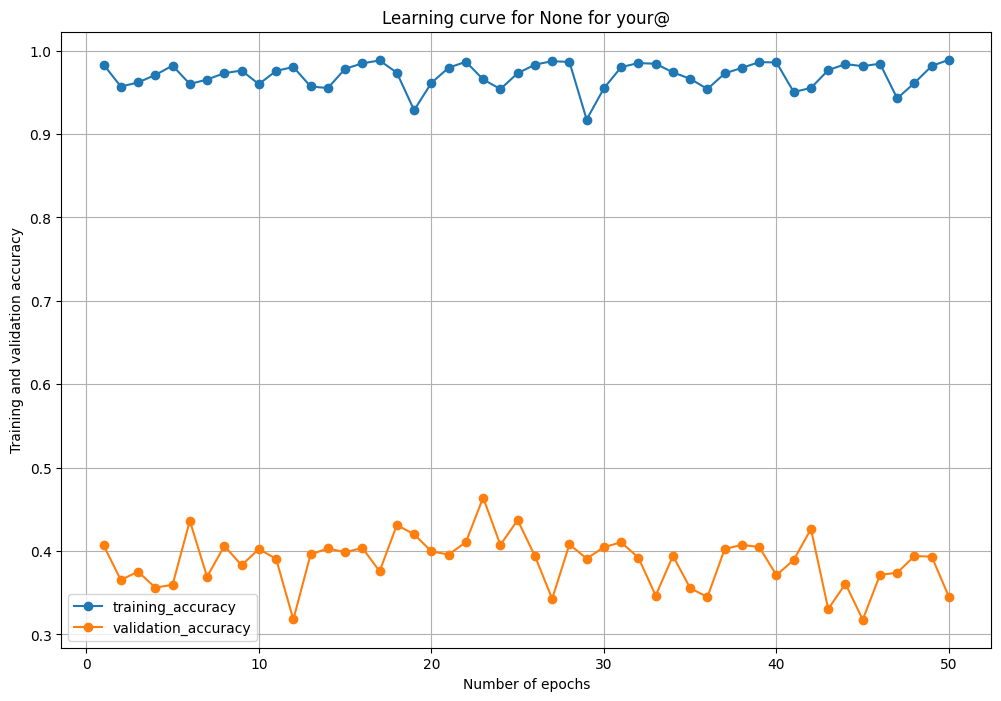

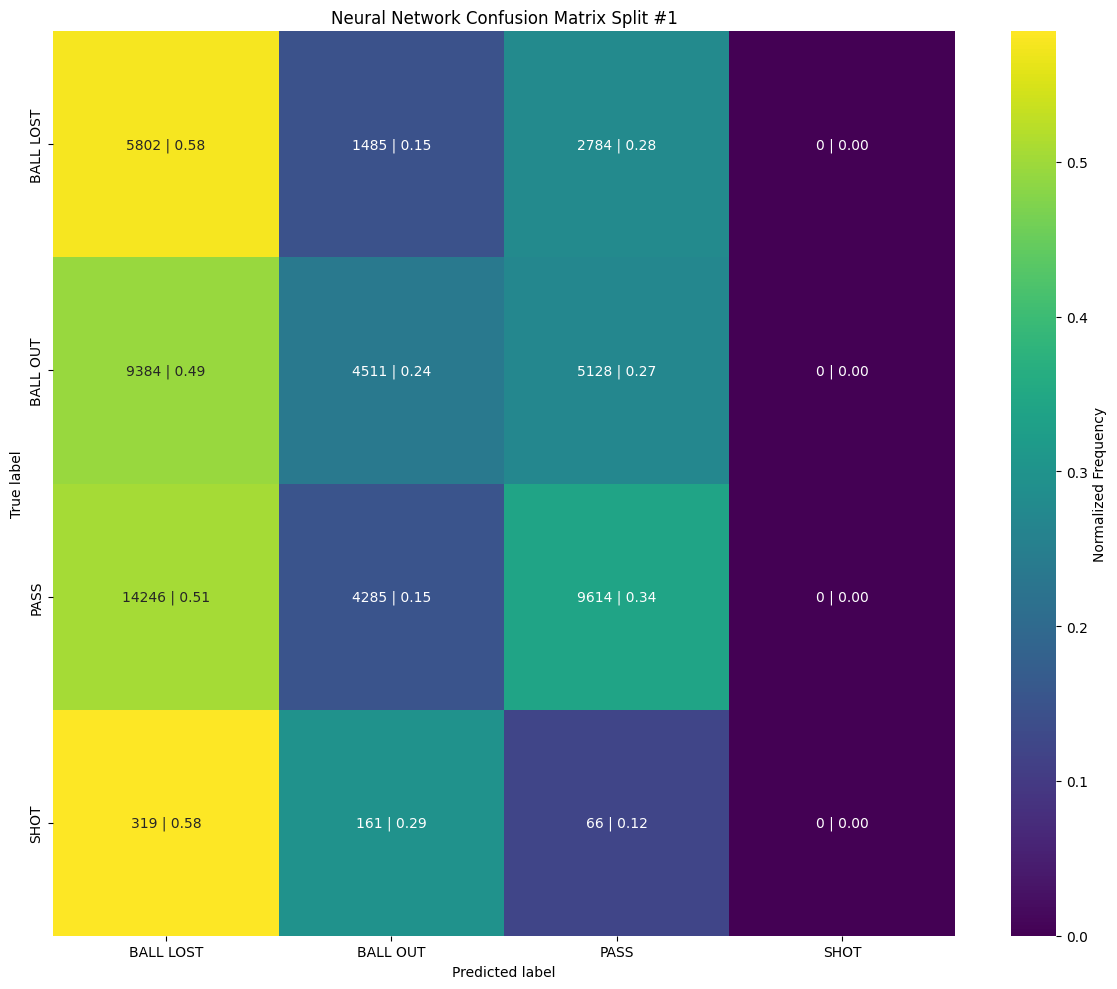

Neural Network training accuracy: 98.92%
Neural Network testing accuracy: 34.48%

Neural Network testing precision: 44.24%
Neural Network testing recall: 34.48%
Neural Network testing f1: 35.63%




In [45]:
plot_accuracy_history(acc, title="None for your@")
labels = label_encoder.inverse_transform(np.unique(y_1_encoded))
_ = plot_confusion_matrix(y_train=label_encoder.inverse_transform(y_train), y_train_pred=label_encoder.inverse_transform(y_train_pred), y_test=label_encoder.inverse_transform(y_true), 
                          y_pred=label_encoder.inverse_transform(y_pred), labels=labels, split=0, model_name="Neural Network")

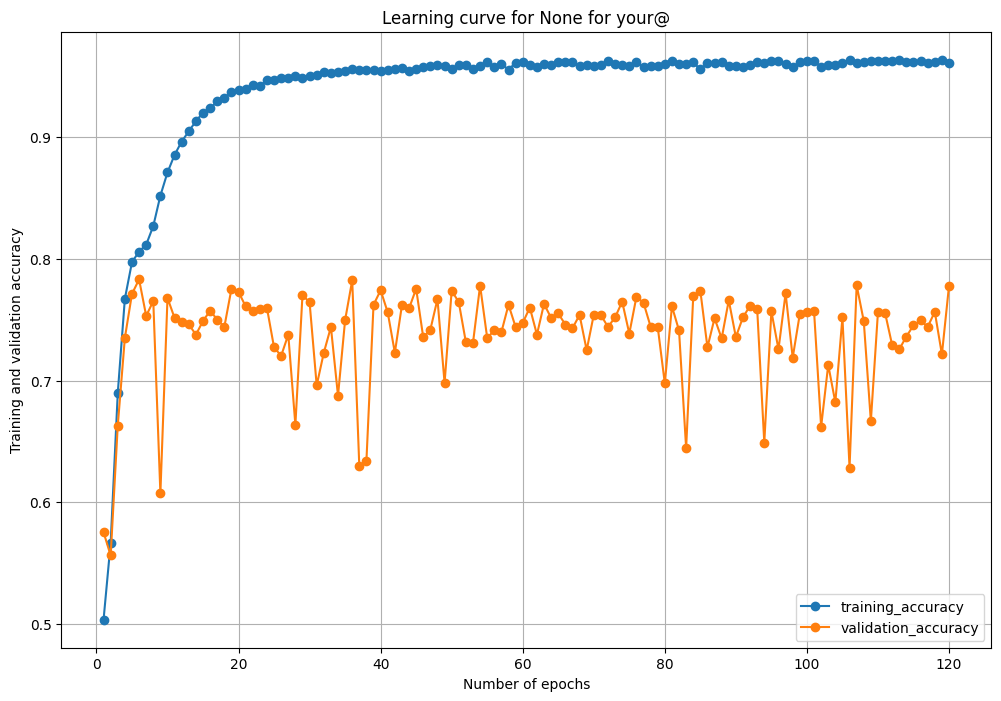

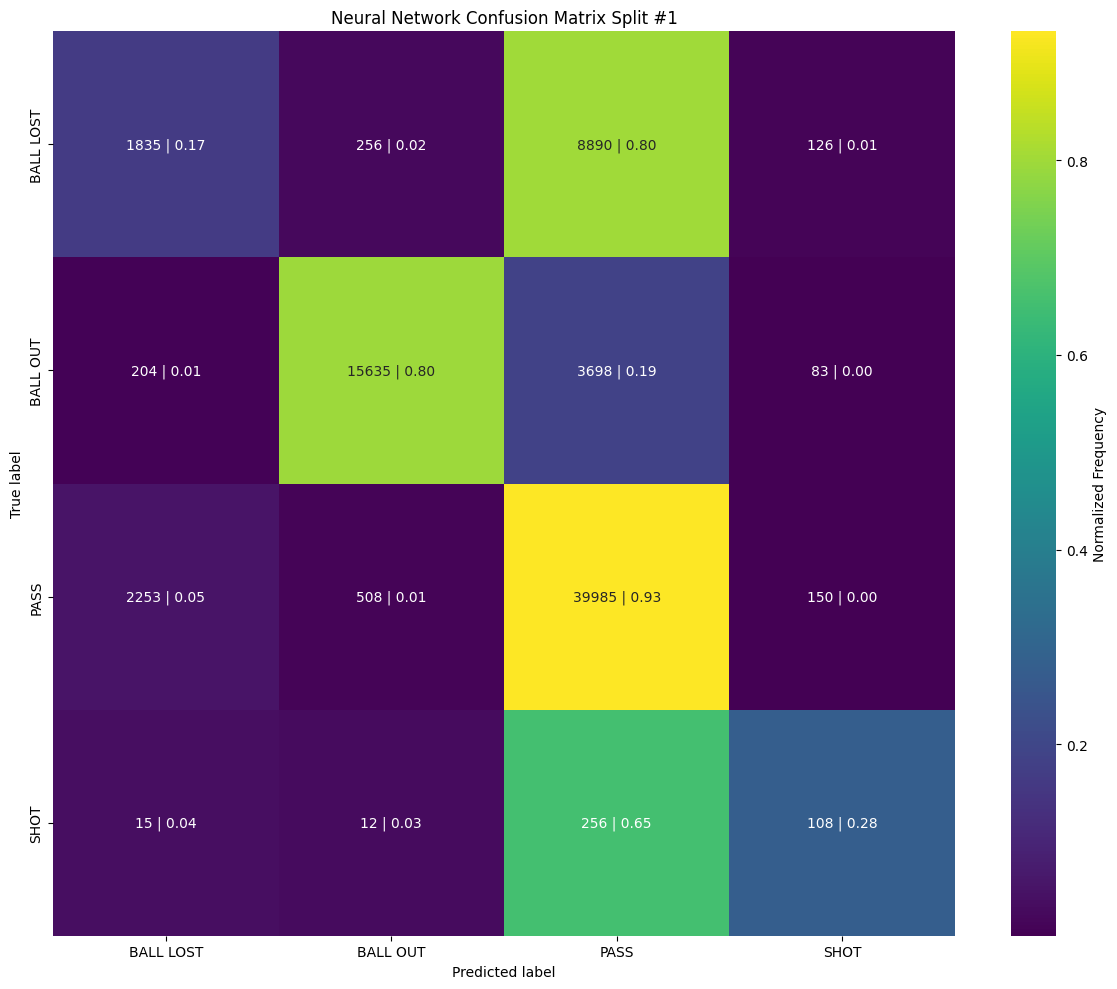

Neural Network training accuracy: 96.09%
Neural Network testing accuracy: 77.77%

Neural Network testing precision: 75.64%
Neural Network testing recall: 77.77%
Neural Network testing f1: 75.13%




In [59]:
plot_accuracy_history(acc, title="None for your@")
labels = label_encoder.inverse_transform(np.unique(y_1_encoded))
_ = plot_confusion_matrix(y_train=label_encoder.inverse_transform(y_train), y_train_pred=label_encoder.inverse_transform(y_train_pred), y_test=label_encoder.inverse_transform(y_true), 
                          y_pred=label_encoder.inverse_transform(y_pred), labels=labels, split=0, model_name="Neural Network")

In [ ]:
plot_accuracy_history(acc, title="None for your")

In [ ]:
plot_accuracy_history(acc, title="More than none for your")

In [ ]:
X_1_tensor = torch.FloatTensor(X_1_scaled)
y_1_tensor = torch.LongTensor(y_1_encoded)

X_2_tensor = torch.FloatTensor(X_2_scaled)
y_2_tensor = torch.LongTensor(y_2_encoded)

X_3_tensor = torch.FloatTensor(X_3_scaled)
y_3_tensor = torch.LongTensor(y_3_encoded)

X = torch.cat((X_1_tensor, X_2_tensor))
y = torch.cat((y_1_tensor, y_2_tensor))

assert X.shape[0] == y.shape[0]

d_1 = TensorDataset(X, y)
d_2 = TensorDataset(X_3_tensor, y_3_tensor)

In [ ]:
def objective(trial):
    batch_size = trial.suggest_categorical('batch_size', [128, 256, 512])
    num_epochs = 150 
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    hidden_size = trial.suggest_categorical('hidden_size', [64, 128, 256, 512])
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'sgd'])
    if optimizer_name == "sgd":
        learning_rate = trial.suggest_float('learning_rate', 1e-2, 1, log=True)
    else:
        learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    num_hidden_layers = trial.suggest_int('num_hidden_layers', 3, 15)

    # Update your model's parameters using the trial's suggestions
    nn_params = {
        "input_size": X_1.shape[1],
        "num_classes": np.unique(y_2).shape[0],
        "num_hidden_layers": num_hidden_layers,
        "dropout_rate": dropout_rate,
        "hidden_size": hidden_size,
    }

    # Recreate the model with the current hyperparameters
    nn_model = get_model("nn", nn_params=nn_params).to(device)

    train_loader = DataLoader(d_1, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(d_2, batch_size=batch_size, shuffle=True)

    # Train the model and get the accuracy (or any other metric)
    acc = train_model(nn_model, train_loader, validation_loader, num_epochs, 
                      optimizer_name=optimizer_name, 
                      criterion=nn.CrossEntropyLoss(), 
                      learning_rate=learning_rate, 
                      device=device, verbose=False)
    
    # Return accuracy as the objective metric (Optuna will try to maximize it)
    # print(np.mean(acc["validation_accuracy"][-20:]))
    return np.mean([np.mean(acc["training_accuracy"][-20:]), np.mean(acc["validation_accuracy"][-20:])])

# Create an Optuna study to optimize the objective
study = optuna.create_study(direction='maximize')  # direction='maximize' because we're optimizing accuracy
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print(f"Best trial: {study.best_trial.params}")
print(f"Best accuracy: {study.best_value}")

In [ ]:
42, 15,13

In [ ]:
def plot_accuracy(history, title=""):
    fig, ax = plt.subplots(figsize=(12, 8))

    for metric, results in history.items():
        ax.plot(list(range(1, num_epochs + 1)), results, marker="o", label=metric)
    # ax.plot(list(range(1, num_epochs + 1)), accuracy["testing_accuracy"], marker="o", label="Testing Accuracy")

    ax.set_xlabel("Number of epochs")
    ax.set_ylabel("Training and validation accuracy")
    ax.set_title(f"Learning curve for {title}")
    
    ax.grid(True)
    ax.legend()
    
    plt.show()

In [ ]:
plot_accuracy(acc, title="NN with MinMax scaling")

In [ ]:
plot_accuracy(acc, title="NN with MinMax scaling")

In [ ]:
plot_accuracy(accu, title="NN with MinMax scaling, added batch normalization, Adam optimizer, and 0.2 dropout")

In [ ]:
plot_accuracy(accuracy, title="NN with minmax scaling, added batch normalization, SGD optimizer, and no dropout")

In [ ]:
plot_accuracy(accu, title="NN with minmax scaling, added batch normalization, SGD optimizer, and 0.1 dropout")

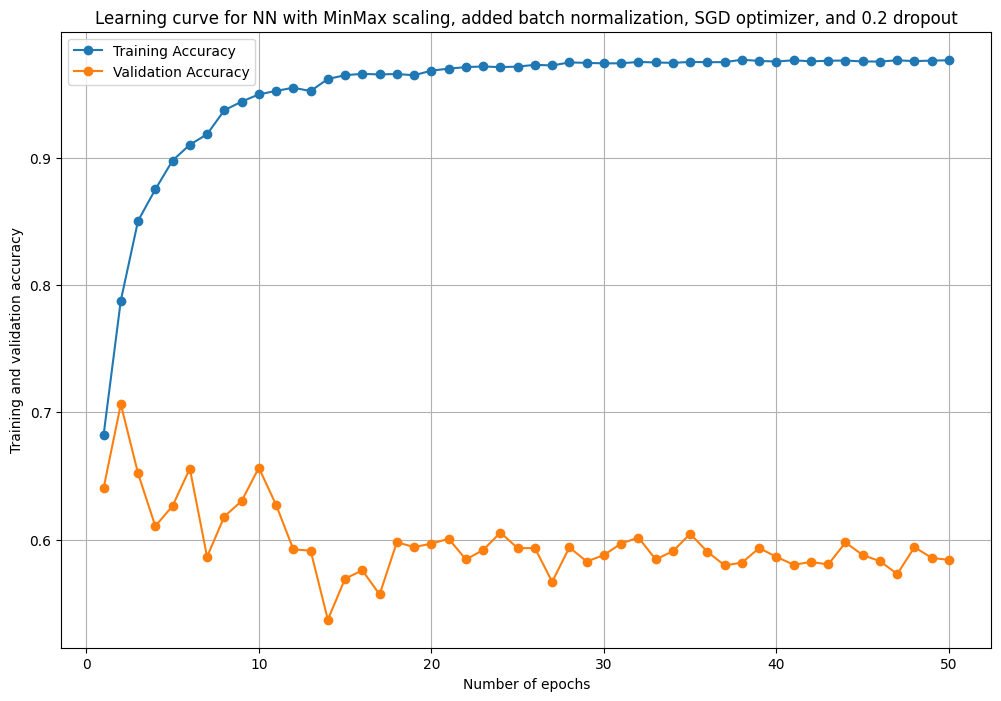

In [62]:
plot_accuracy(accu, title="NN with MinMax scaling, added batch normalization, SGD optimizer, and 0.2 dropout")